In [1]:
import numpy as np
import math
from scipy.stats import norm
from scipy.optimize import linprog
from matplotlib import pyplot as plt

# Графики функции выплат

Пример 1. Постройте графики функции выплат для опционов колл (покупка, продажа) и пут (покупка, продажа).

In [2]:
def payoff_buy_call(S, K):
    return np.maximum(S - K, 0)

def payoff_buy_put(S, K):
    return np.maximum(K - S, 0)

def payoff_sell_call(S, K):
    return -payoff_buy_call(S, K)

def payoff_sell_put(S, K):
    return -payoff_buy_put(S, K)

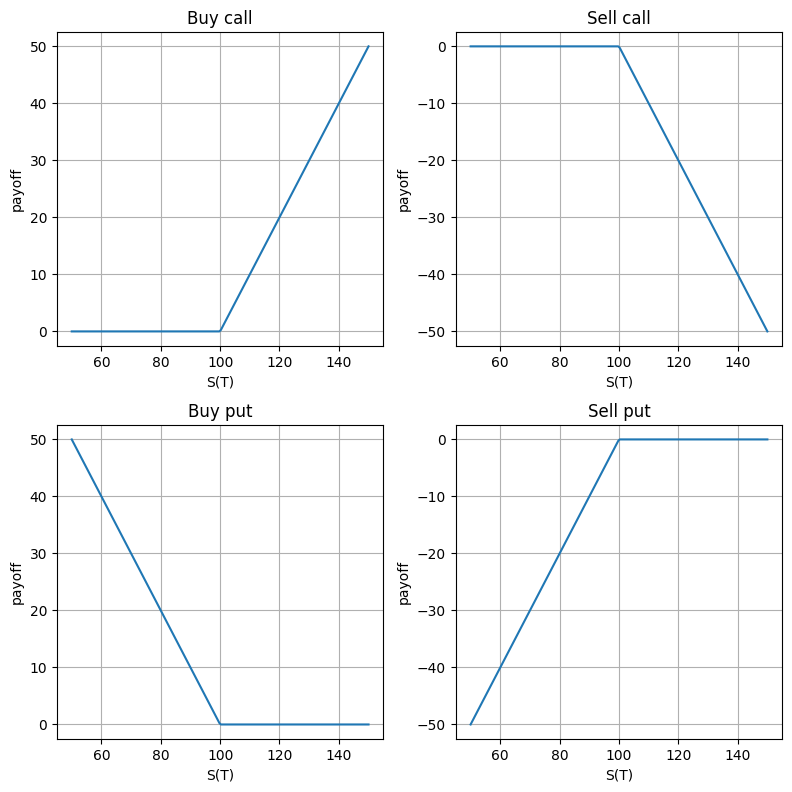

In [3]:
K = 100
S = np.linspace(50, 150, 200)

fig, ax = plt.subplots(2, 2, figsize = (8,8))
ax[0][0].plot(S, payoff_buy_call(S, K))
ax[0][0].set_xlabel("S(T)")
ax[0][0].set_ylabel("payoff")
ax[0][0].grid(True)
ax[0][0].set_title("Buy call")

ax[0][1].plot(S, payoff_sell_call(S, K))
ax[0][1].set_xlabel("S(T)")
ax[0][1].set_ylabel("payoff")
ax[0][1].grid(True)
ax[0][1].set_title("Sell call")

ax[1][0].plot(S, payoff_buy_put(S, K))
ax[1][0].set_xlabel("S(T)")
ax[1][0].set_ylabel("payoff")
ax[1][0].grid(True)
ax[1][0].set_title("Buy put")

ax[1][1].plot(S, payoff_sell_put(S, K))
ax[1][1].set_xlabel("S(T)")
ax[1][1].set_ylabel("payoff")
ax[1][1].grid(True)
ax[1][1].set_title("Sell put")

fig.tight_layout(pad=1.0)

## Задача (Collar)

  Допустим, что текущая цена базового актива равна 70.65, страйки опциона пут и колл равны 65 и 75 соответственно, а оценки их стоимости (премии) равны 2 и 3.25 соответственно. Постройте стратегию, которая заключается в покупке опциона пут и продаже опциона колл.

Определите максимальную прибыль и потери, если цена базового актива может вырасти в два раза (меньше нуля не может быть). Определите интервал безубыточности стратегии с учетом премии. Постройте график функции выплат для опционной стратегии.

https://blog.quantinsti.com/collar-options-trading-strategy-python/


In [4]:
# Цена базового актива
S = 70.65

# Long put
K_long_put = 65
premium_long_put = 2

# Short call
K_short_call = 75
premium_short_call = 3.25

## Задача (Long Straddle)

Допустим, что текущая цена базового актива равна 172.5, страйки опциона пут и колл однинаковые и равны 200, а премии опционов равны 29.25 и 0.04 соответственно. Постройте стратегию, которая заключается в покупке опциона пут и покупке опциона колл.

Определите максимальную прибыль и потери, если цена базового актива может вырасти в два раза (меньше нуля не может быть). Определите интервал безубыточности стратегии с учетом премии. Постройте график функции выплат для опционной стратегии.

https://blog.quantinsti.com/straddle-options-trading-strategy-python/

In [5]:
# Цена базового актива
S = 172.5

# Long put
K_long_put = 200
premium_long_put = 29.25

# Long call
K_long_call = 200
premium_long_call = 0.04

# Биноминальная модель

In [6]:
# plot_binomial_tree: visualisation of the tree and state prices
def plot_binomial_tree(statePrices, n):
    for i in range(0,n+1):
        for j in range(0,n+1):
            if j>i:
                break
            if i<n:
                x1, y1 = [i, i+1], [2*j-(i-1),2*j+1-(i-1)]
                plt.plot(x1, y1, marker = 'o',color="red")
                x1, y1 = [i, i+1], [2*j-(i-1),2*j-1-(i-1)]
                plt.plot(x1, y1, marker = 'o',color="black")
            plt.text(i-0.2,2*j-(i-1)-0.6,"%.2f" % statePrices["payoff"][i][j])
            plt.text(i-0.2,2*j-(i-1)-1.0,"%.2f" % statePrices["underlying"][i][j],color="blue")
    plt.title("Биноминальное дерево")
    plt.xlabel("p=%.1f%%, u=%.3f, r=%.2f%%, q=%.2f%%, dt=%.2fdays" % (statePrices["p"]*100,
                                                                   statePrices["u"],
                                                                   statePrices["r"]*100,
                                                                   statePrices["q"]*100,
                                                                   statePrices["dt"]*365))
    plt.show()

In [7]:
# binomial_tree_pricer

def binomial_tree_pricer(r, q, sigma, T, n, S, payoff, american=True, showStatePrices=False):
# r: risk neutral rate
# q: dividend yield
# sigma: volatility
# T: maturity in years
# n: number of time steps
# S: spot stock price
# payoff: payoff function e.g.: lambda S: max(S-K,0)
# american: early exercise: True if american, otherwise European
# showStatePrices: print tree probabilities and state prices

    dt = T/n
    up  = np.exp(sigma*np.sqrt(dt))
    p0 = (up * np.exp((r-q) * dt) - 1) / (up**2 - 1)
    p1 = 1 - p0
    df = np.exp(-r * dt)
    # initial values at time T
    statePrices = {"p":p0, "u":up, "r":r, "q":q, "dt":dt}
    if showStatePrices:
        statePrices["payoff"]=np.zeros((n+1,n+1))
        statePrices["underlying"]=np.zeros((n+1,n+1))
    p = np.zeros(n+1)
    for i in range(n+1): # i from 0 to n incl
        p[i] = payoff(S * up**(2*i - n))
        if showStatePrices:
            statePrices["payoff"][n][i] = p[i]
            statePrices["underlying"][n][i] = S * up**(2*i - n)
    # move to earlier times
    for j in range(n-1,-1,-1): # j from n-1 to 0 incl
        for i in range(j+1): # i from 0 to j incl
            # discounted expected value of exdiv price
            p[i] = (p0 * p[i+1] + p1 * p[i])*df
            # american payoff
            if american:
                early_exercise = payoff(S * up**(2*i - j))
                p[i] = max(early_exercise,p[i])
            if showStatePrices:
                statePrices["payoff"][j][i] = p[i]
                statePrices["underlying"][j][i] = S * up**(2*i - j)
    if showStatePrices:
        plot_binomial_tree(statePrices, n)
    return p[0]

## Задача (дерево)

Задача. Постройте биноминальные деревья для
*   американского опциона колл,
*   американского опциона пут,
*   европейского опциона колл,
*   европейского опциона пут
и сделайте выводы.





Пример. Текущая цена акций равна 50, волатильность 15%, цена страйк на 1% выше цены базового актива, время до экспирации 1 месяц, безрисковая ставка 5%, на акции начисляются дивиденды 2%.

Биноминальное дерево, американского опциона колл, функция выплат max(S-K, 0)


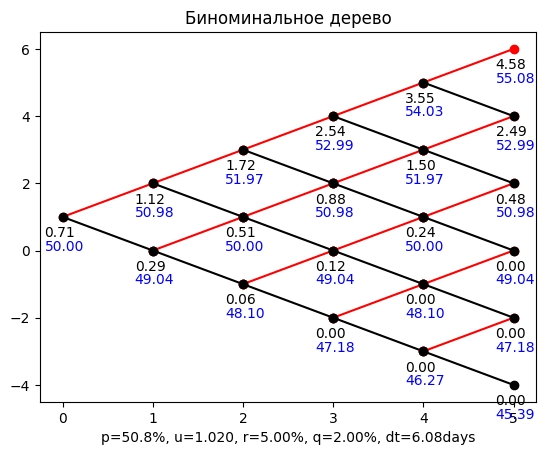

np.float64(0.7120324211650718)

In [8]:
r, q, sigma, T, n, S = 0.05, 0.02, 0.15, 1/12, 5, 50
K = S*1.01
print("Биноминальное дерево, американского опциона колл, функция выплат max(S-K, 0)")
binomial_tree_pricer(r, q, sigma, T, n, S, lambda S: max(S-K,0), american=True, showStatePrices=True)

Биноминальное дерево, американского опцион пут, функция выплат max(K-S, 0)


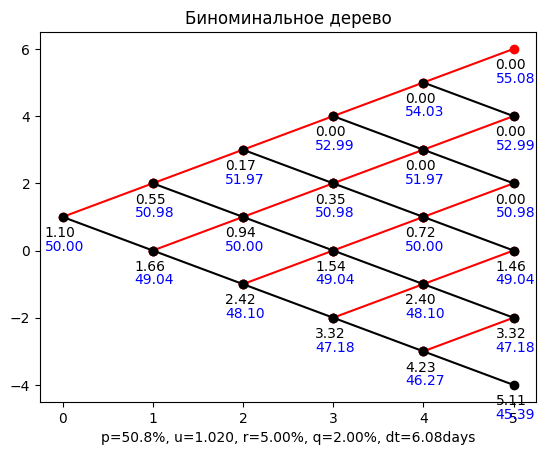

np.float64(1.0962783164249443)

In [9]:
r, q, sigma, T, n, S = 0.05, 0.02, 0.15, 1/12, 5, 50
K = S*1.01
print("Биноминальное дерево, американского опцион пут, функция выплат max(K-S, 0)")
binomial_tree_pricer(r, q, sigma, T, n, S, lambda S: max(K-S,0), american=True, showStatePrices=True)

Биноминальное дерево, европейский опцион колл, функция выплат max(S-K, 0)


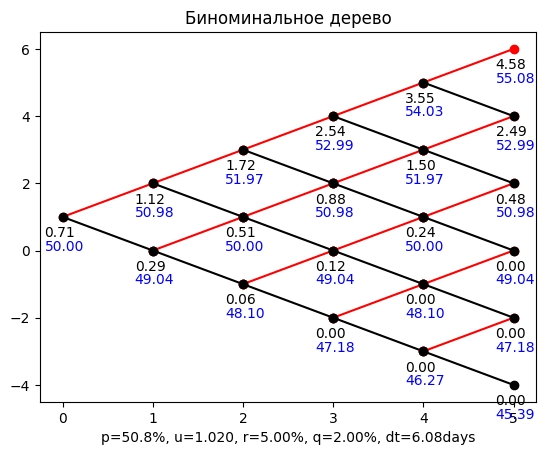

np.float64(0.7120324211650718)

In [10]:
r, q, sigma, T, n, S = 0.05, 0.02, 0.15, 1/12, 5, 50
K = S*1.01
print("Биноминальное дерево, европейский опцион колл, функция выплат max(S-K, 0)")
binomial_tree_pricer(r, q, sigma, T, n, S, lambda S: max(S-K,0), american=False, showStatePrices=True)

Биноминальное дерево, европейский опцион пут, функция выплат max(K-S, 0)


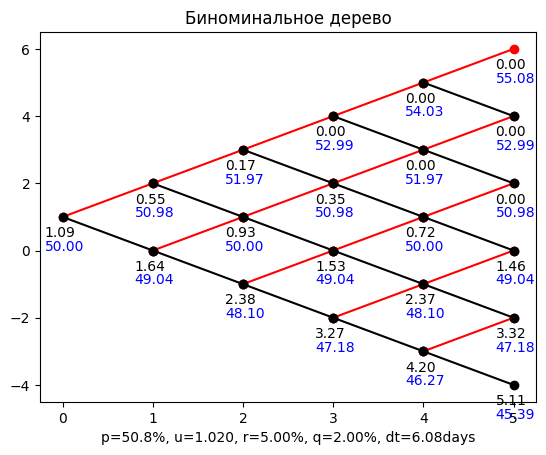

np.float64(1.0853174417962133)

In [11]:
r, q, sigma, T, n, S = 0.05, 0.02, 0.15, 1/12, 5, 50
K = S*1.01
print("Биноминальное дерево, европейский опцион пут, функция выплат max(K-S, 0)")
binomial_tree_pricer(r, q, sigma, T, n, S, lambda S: max(K-S,0), american=False, showStatePrices=True)

# Выводы
Американские опционы: Для американских опционов на каждом шаге дерева проверяется, не выгодно ли выполнить опцион досрочно. Это приводит к более высокой стоимости по сравнению с европейскими опционами, если есть возможность досрочного исполнения.

Европейские опционы: У европейских опционов нет такой возможности, поэтому их цена всегда меньше или равна цене американских опционов при прочих равных условиях.

# Модель Блека-Шоулза

Задача. Допустим, что условия модели Блека-Шоулза выполнены. Текущая цена бездивидентных акций равна 100, волатальность
5%, цена страйк 100, время до экспирации один год, безрисковая
ставка 5%.

Оцените справедливую стоимость опционов колл и пут и вычислите греческие характеристики для опционов как функцию от текущей цены базового актива.

In [12]:
r = 0.07
T = 1
K = 100
S0 = 100
sigma = 0.3
t = 0
q = 0
tau = T - t

## Задача (оценка и паритет)

In [13]:
# оценка опциона колл
def call(S, K, T, sigma, r, q):
    d1 = (np.log (S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * np.exp(-q * T) * norm.cdf(d1) - K * np.exp (-r * T) * norm.cdf(d2)

In [14]:
# оценка опциона пут
def put(S, K, T, sigma, r, q):
    d1 = (math.log(S / K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * math.sqrt(T))
    d2 = d1 - sigma * math.sqrt(T)
    
    return K * math.exp(-r * T) * norm.cdf(-d2) - S * math.exp(-q * T) * norm.cdf(-d1)

In [15]:
# оценка опциона пут с использованием паритета
def put_paritet(S, K, T, sigma, r, q):
    return call(S, K, T, sigma, r, q) + K * np.exp(-r * T) - S

Сравните результаты оценки опциона пут с/без паритета цен

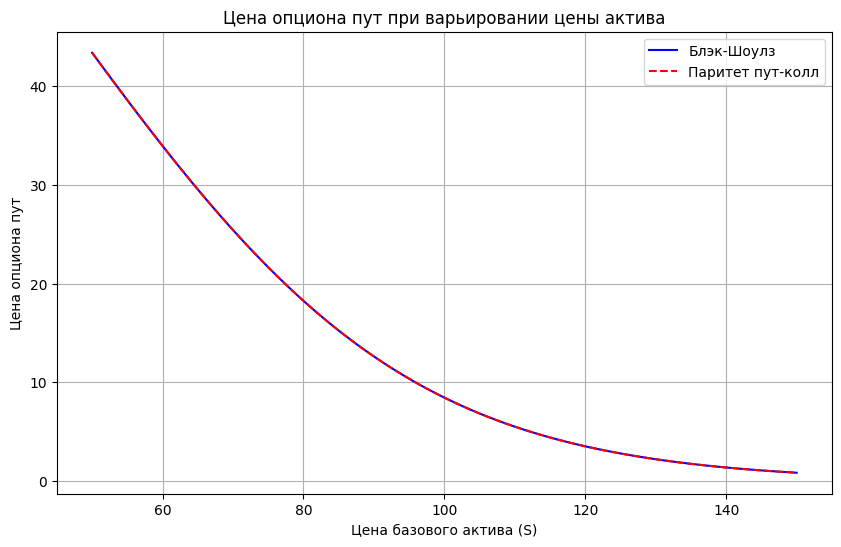

In [16]:
S_range = np.linspace(50, 150, 100)

# Рассчитаем цены пут-опциона для каждого значения S
put_prices = [put(S, K, T, sigma, r, q) for S in S_range]
put_prices_paritet = [put_paritet(S, K, T, sigma, r, q) for S in S_range]

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(S_range, put_prices, label="Блэк-Шоулз", color="blue")
plt.plot(S_range, put_prices_paritet, label="Паритет пут-колл", color="red", linestyle="--")
plt.title("Цена опциона пут при варьировании цены актива")
plt.xlabel("Цена базового актива (S)")
plt.ylabel("Цена опциона пут")
plt.legend()
plt.grid()
plt.show()

In [17]:
params = f"r = {r}, sigma = {sigma}, t = {t}, T = {T}, S0 = {S0}, K = {K}"
print('Параметры:', params)

call_price = call(S0, K, T, sigma, r, q)
print('Оценка опциона колл =', call_price)
put_price = put(S0, K, T, sigma, r, q)
print('Оценка опциона пут =', put_price)

Параметры: r = 0.07, sigma = 0.3, t = 0, T = 1, S0 = 100, K = 100
Оценка опциона колл = 15.210500635727158
Оценка опциона пут = 8.449882626321987


## Задача (греческие характеристики)

Вспомогательные функции для аналитического вычисления греческих характеристик.

In [18]:
def delta(S, K, r, T, sigma, option_type):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    if option_type == 'call':
        return norm.cdf(d1)
    elif option_type == 'put':
        return -norm.cdf(-d1)

def gamma(S, K, r, T, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    return norm.pdf(d1) / (S * sigma * np.sqrt(T))

def theta(S, K, r, T, sigma, option_type):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == 'call':
        return -(S * norm.pdf(d1) * sigma) / (2 * np.sqrt(T)) - r * K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == 'put':
        return -(S * norm.pdf(d1) * sigma) / (2 * np.sqrt(T)) + r * K * np.exp(-r * T) * norm.cdf(-d2)

def kappa(S, K, r, T, sigma, option_type):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == 'call':
        return -np.exp(-r*T)*norm.cdf(d2) 
    elif option_type == 'put':
        return np.exp(-r * T) * norm.cdf(-d2)

def vega(S, K, r, T, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    return S * norm.pdf(d1) * np.sqrt(T)

def rho(S, K, r, T, sigma, option_type):
    d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    if option_type == 'call':
        return K * T * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == 'put':
        return -K * T * np.exp(-r * T) * norm.cdf(-d2)

Графики зависимости греческих характеристик для опционов от цены базового актива.

In [19]:
def draw_graphs(K=100, r=0.07, T=1, sigma=0.2, N=1000, option_type='call'):
    titles = ['Delta', 'Gamma', 'Theta', 'Kappa', 'Vega', 'Rho']
    functions = [delta, gamma, theta, kappa, vega, rho]
    
    fig, axs = plt.subplots(2, 3, figsize=(18, 12))
    
    for i, (func, title) in enumerate(zip(functions, titles)):
        row = i // 3
        col = i % 3
        ax = axs[row, col]
        
        # Диапазон цен базового актива S
        X = np.linspace(1, np.exp(-r * T) * K * 2, N)
        
        # Вычисление значений греческой буквы
        if func.__name__ == 'gamma' or func.__name__ == 'vega':
            values = [func(S, K, r, T, sigma) for S in X]
        else:
            values = [func(S, K, r, T, sigma, option_type) for S in X]
        
        # Построение графика
        ax.plot(X, values, label=title, color='blue')
        ax.set_title(title, fontsize=14)
        ax.set_xlabel("Цена базового актива (S)", fontsize=12)
        ax.set_ylabel(f"{title} значение", fontsize=12)
        ax.grid(True)
        ax.legend()
    
    plt.tight_layout()
    plt.show()

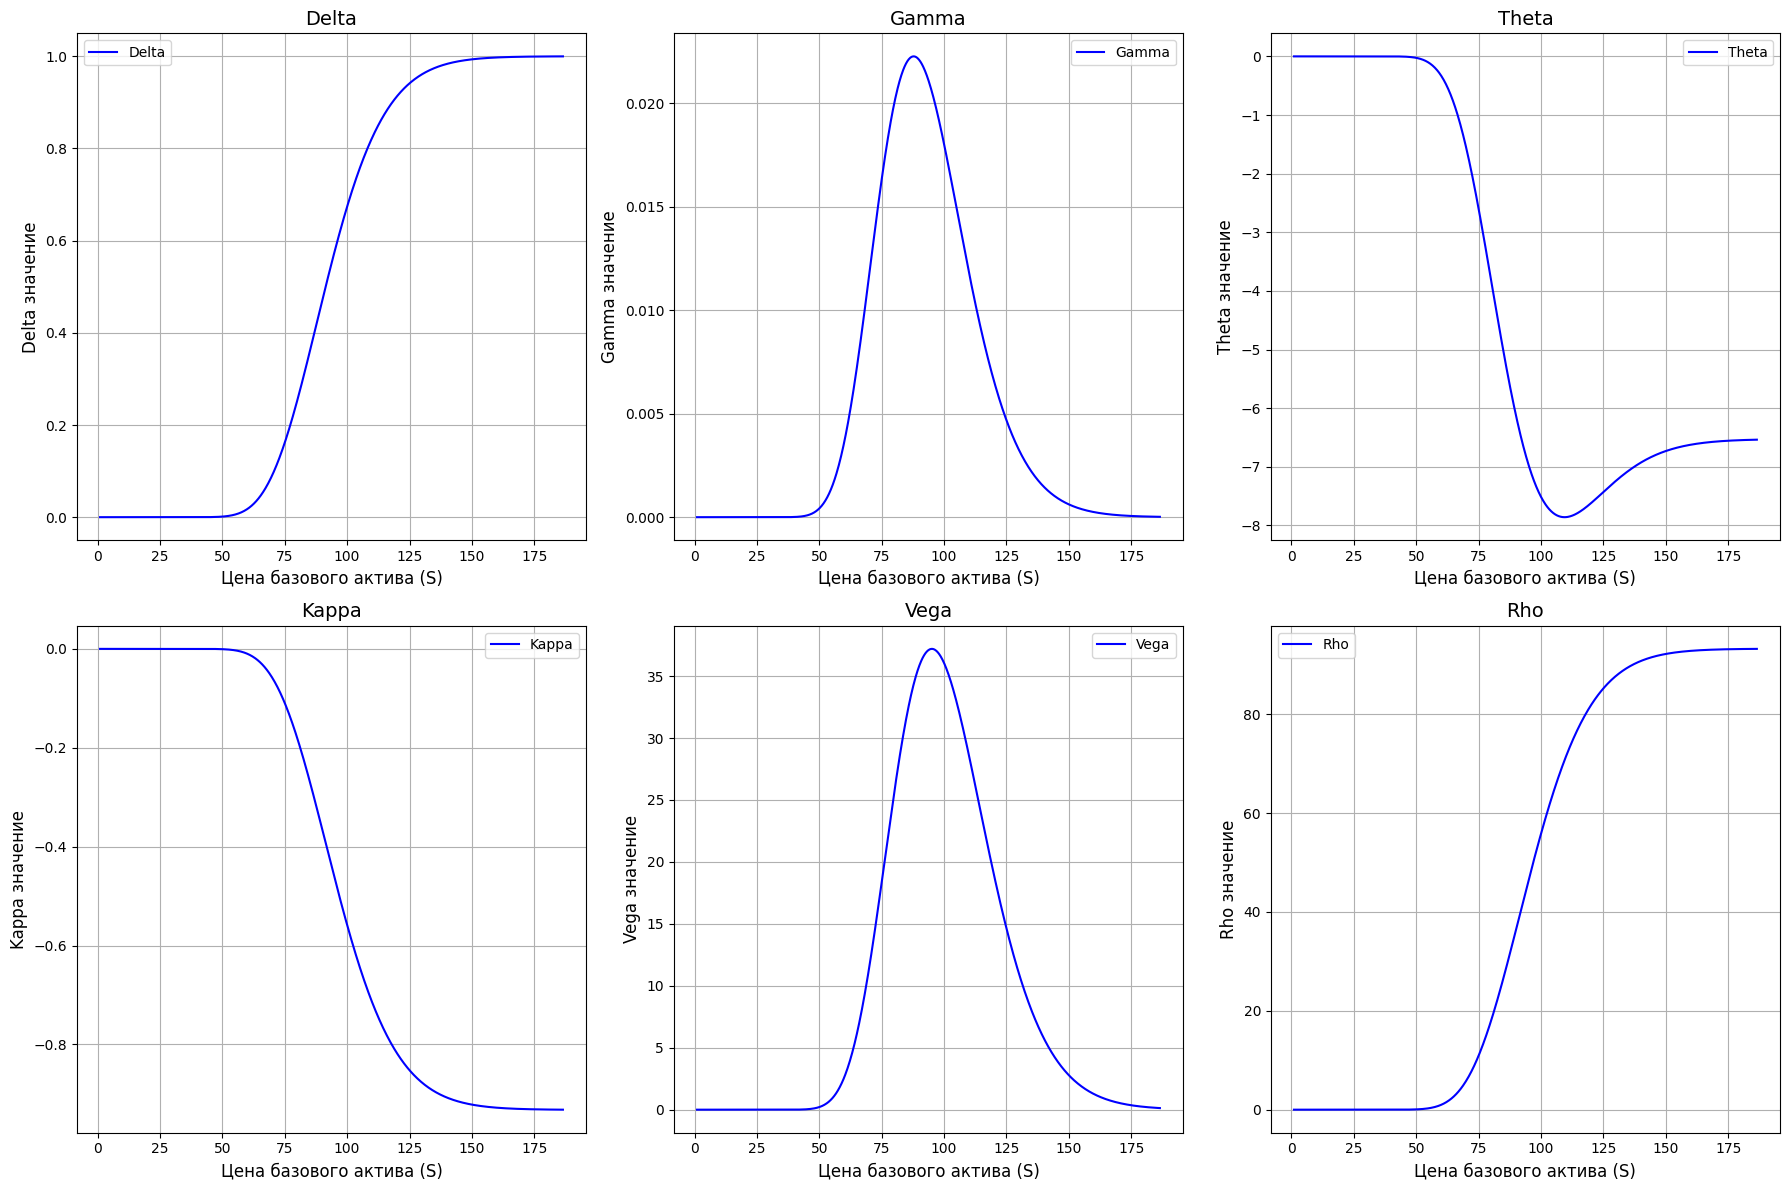

In [20]:
draw_graphs(option_type='call')

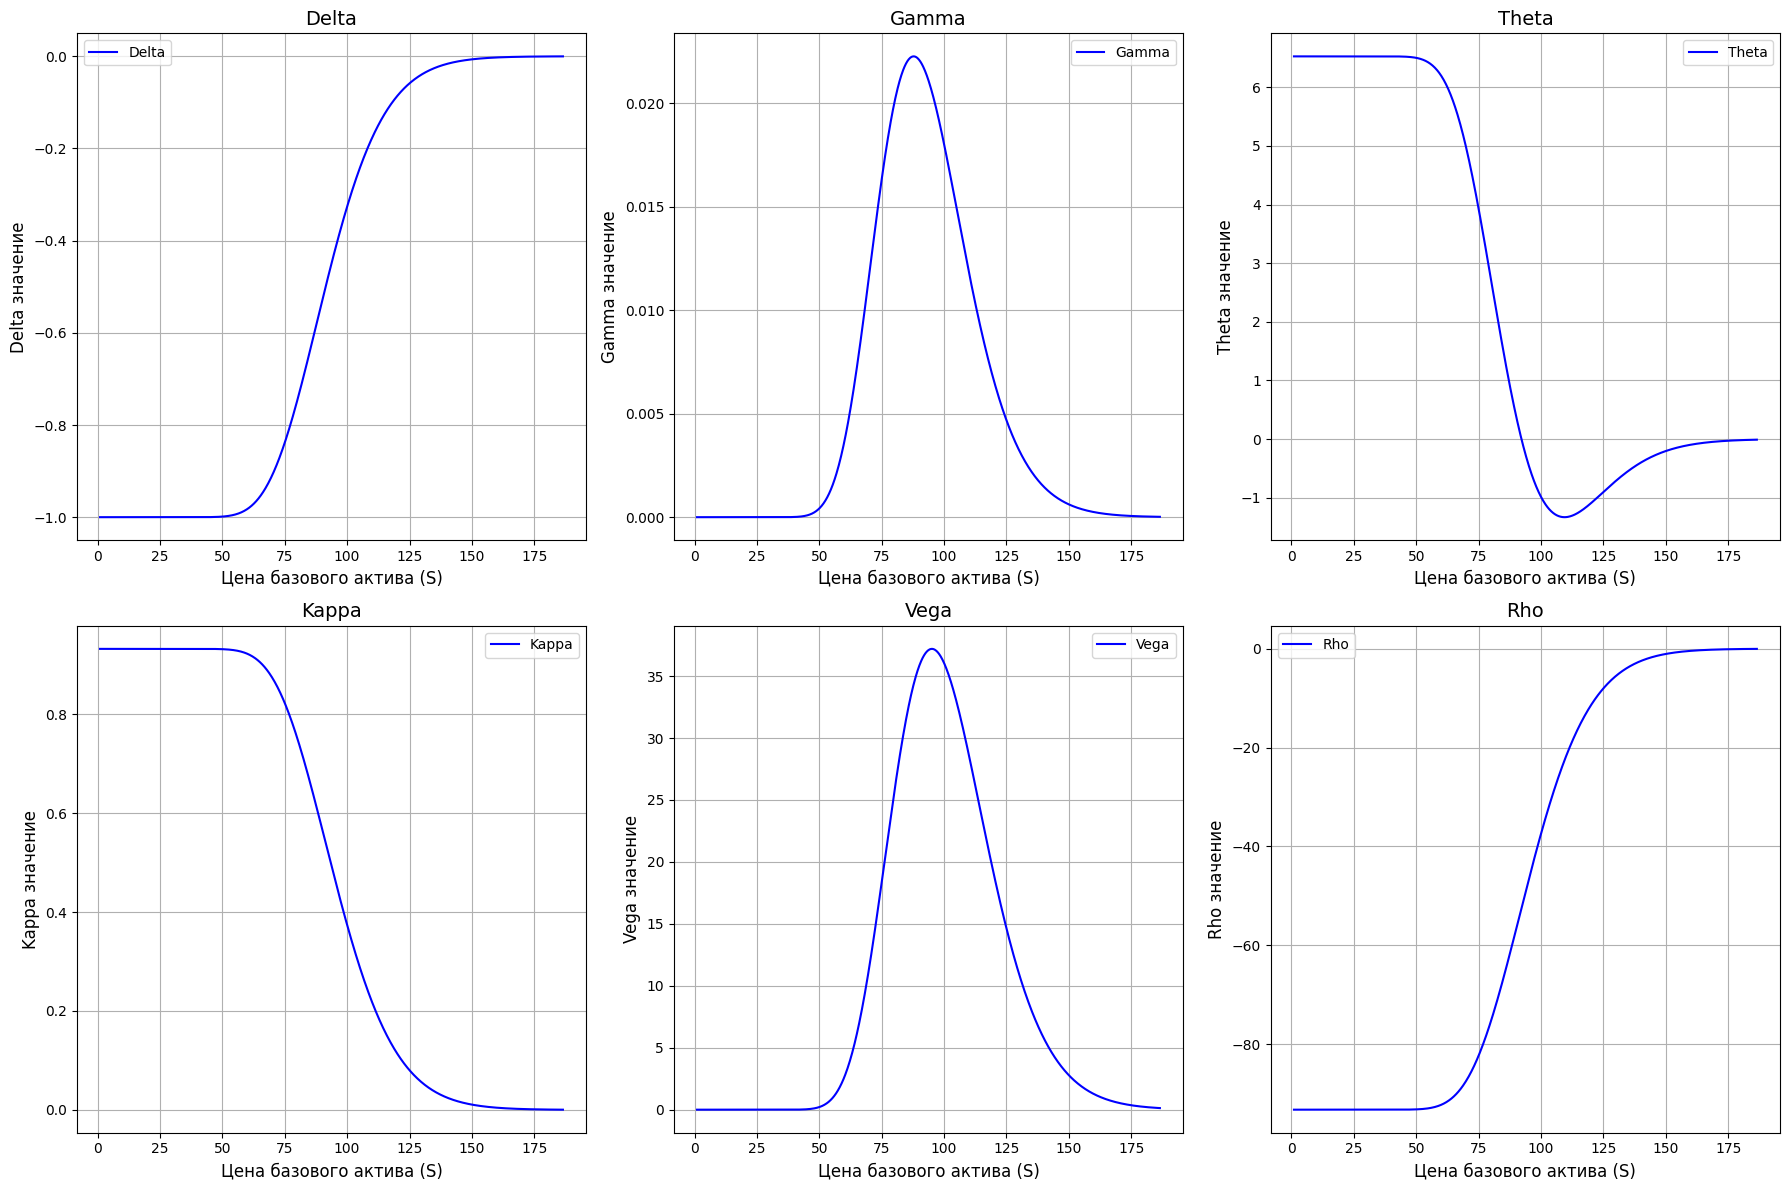

In [21]:
draw_graphs(option_type='put')

Задача. Вычислите греческие коэффициенты численно и сравните результаты.

```
def first_derivative(f, x, h=0.001):
    return (f(x + h) - f(x - h)) / (2 * h)

def second_derivative(f, x, h=0.001):
    return (f(x + h) - 2 * f(x) + f(x - h)) / (h * h)
```




In [22]:
# Функция для расчета цены опциона по модели Блэка-Шоулза
def option_price(S, K, r, T, sigma, option_type):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if option_type == 'call':
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == 'put':
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

# Численные приближения греков
def numerical_delta(S, K, r, T, sigma, option_type, h=0.001):
    return (option_price(S + h, K, r, T, sigma, option_type) - 
            option_price(S - h, K, r, T, sigma, option_type)) / (2 * h)

def numerical_gamma(S, K, r, T, sigma, option_type, h=0.001):
    return (option_price(S + h, K, r, T, sigma, option_type) - 
            2 * option_price(S, K, r, T, sigma, option_type) + 
            option_price(S - h, K, r, T, sigma, option_type)) / (h ** 2)

def numerical_vega(S, K, r, T, sigma, option_type, h=0.001):
    return (option_price(S, K, r, T, sigma + h, option_type) - 
            option_price(S, K, r, T, sigma - h, option_type)) / (2 * h)

def numerical_theta(S, K, r, T, sigma, option_type, h=0.001):
    return (option_price(S, K, r, T - h, sigma, option_type) - 
            option_price(S, K, r, T + h, sigma, option_type)) / (2 * h)

def numerical_rho(S, K, r, T, sigma, option_type, h=0.001):
    return (option_price(S, K, r + h, T, sigma, option_type) - 
            option_price(S, K, r - h, T, sigma, option_type)) / (2 * h)

def numerical_kappa(S, K, r, T, sigma, option_type, h=0.001):
    return (option_price(S, K + h, r, T, sigma, option_type) - 
            option_price(S, K - h, r, T, sigma, option_type)) / (2 * h)

In [23]:
def plot_numerical_greeks(S, K, r, T, sigma, option_type):
    # Вычисляем точные значения греков
    delta_exact = [delta(s, K, r, T, sigma, option_type) for s in S]
    gamma_exact = [gamma(s, K, r, T, sigma) for s in S]
    vega_exact = [vega(s, K, r, T, sigma) for s in S]
    theta_exact = [theta(s, K, r, T, sigma, option_type) for s in S]
    rho_exact = [rho(s, K, r, T, sigma, option_type) for s in S]
    kappa_exact = [kappa(s, K, r, T, sigma, option_type) for s in S]

    # Численные значения греков
    delta_numerical = [numerical_delta(s, K, r, T, sigma, option_type) for s in S]
    gamma_numerical = [numerical_gamma(s, K, r, T, sigma, option_type) for s in S]
    vega_numerical = [numerical_vega(s, K, r, T, sigma, option_type) for s in S]
    theta_numerical = [numerical_theta(s, K, r, T, sigma, option_type) for s in S]
    rho_numerical = [numerical_rho(s, K, r, T, sigma, option_type) for s in S]
    kappa_numerical = [numerical_kappa(s, K, r, T, sigma, option_type) for s in S]

    # Построение графиков
    plt.figure(figsize=(18, 12))

    plt.subplot(2, 3, 1)
    plt.plot(S, delta_exact, label='Delta (Exact)')
    plt.plot(S, delta_numerical, '--', label='Delta (Numerical)')
    plt.xlabel('S')
    plt.ylabel('Delta')
    plt.legend()
    plt.title('Delta Comparison')

    plt.subplot(2, 3, 2)
    plt.plot(S, gamma_exact, label='Gamma (Exact)')
    plt.plot(S, gamma_numerical, '--', label='Gamma (Numerical)')
    plt.xlabel('S')
    plt.ylabel('Gamma')
    plt.legend()
    plt.title('Gamma Comparison')

    plt.subplot(2, 3, 3)
    plt.plot(S, theta_exact, label='Theta (Exact)')
    plt.plot(S, theta_numerical, '--', label='Theta (Numerical)')
    plt.xlabel('S')
    plt.ylabel('Theta')
    plt.legend()
    plt.title('Theta Comparison')

    plt.subplot(2, 3, 4)
    plt.plot(S, kappa_exact, label='Kappa (Exact)')
    plt.plot(S, kappa_numerical, '--', label='Kappa (Numerical)')
    plt.xlabel('S')
    plt.ylabel('Kappa')
    plt.legend()
    plt.title('Kappa Comparison')

    plt.subplot(2, 3, 5)
    plt.plot(S, vega_exact, label='Vega (Exact)')
    plt.plot(S, vega_numerical, '--', label='Vega (Numerical)')
    plt.xlabel('S')
    plt.ylabel('Vega')
    plt.legend()
    plt.title('Vega Comparison')

    plt.subplot(2, 3, 6)
    plt.plot(S, rho_exact, label='Rho (Exact)')
    plt.plot(S, rho_numerical, '--', label='Rho (Numerical)')
    plt.xlabel('S')
    plt.ylabel('Rho')
    plt.legend()
    plt.title('Rho Comparison')

    plt.tight_layout()
    plt.show()

In [24]:
# Задаем параметры
S = np.linspace(1, 175, 100)  # цены базового актива
K = 100  # страйк
r = 0.07  # процентная ставка
T = 1  # время до исполнения
sigma = 0.2  # волатильность


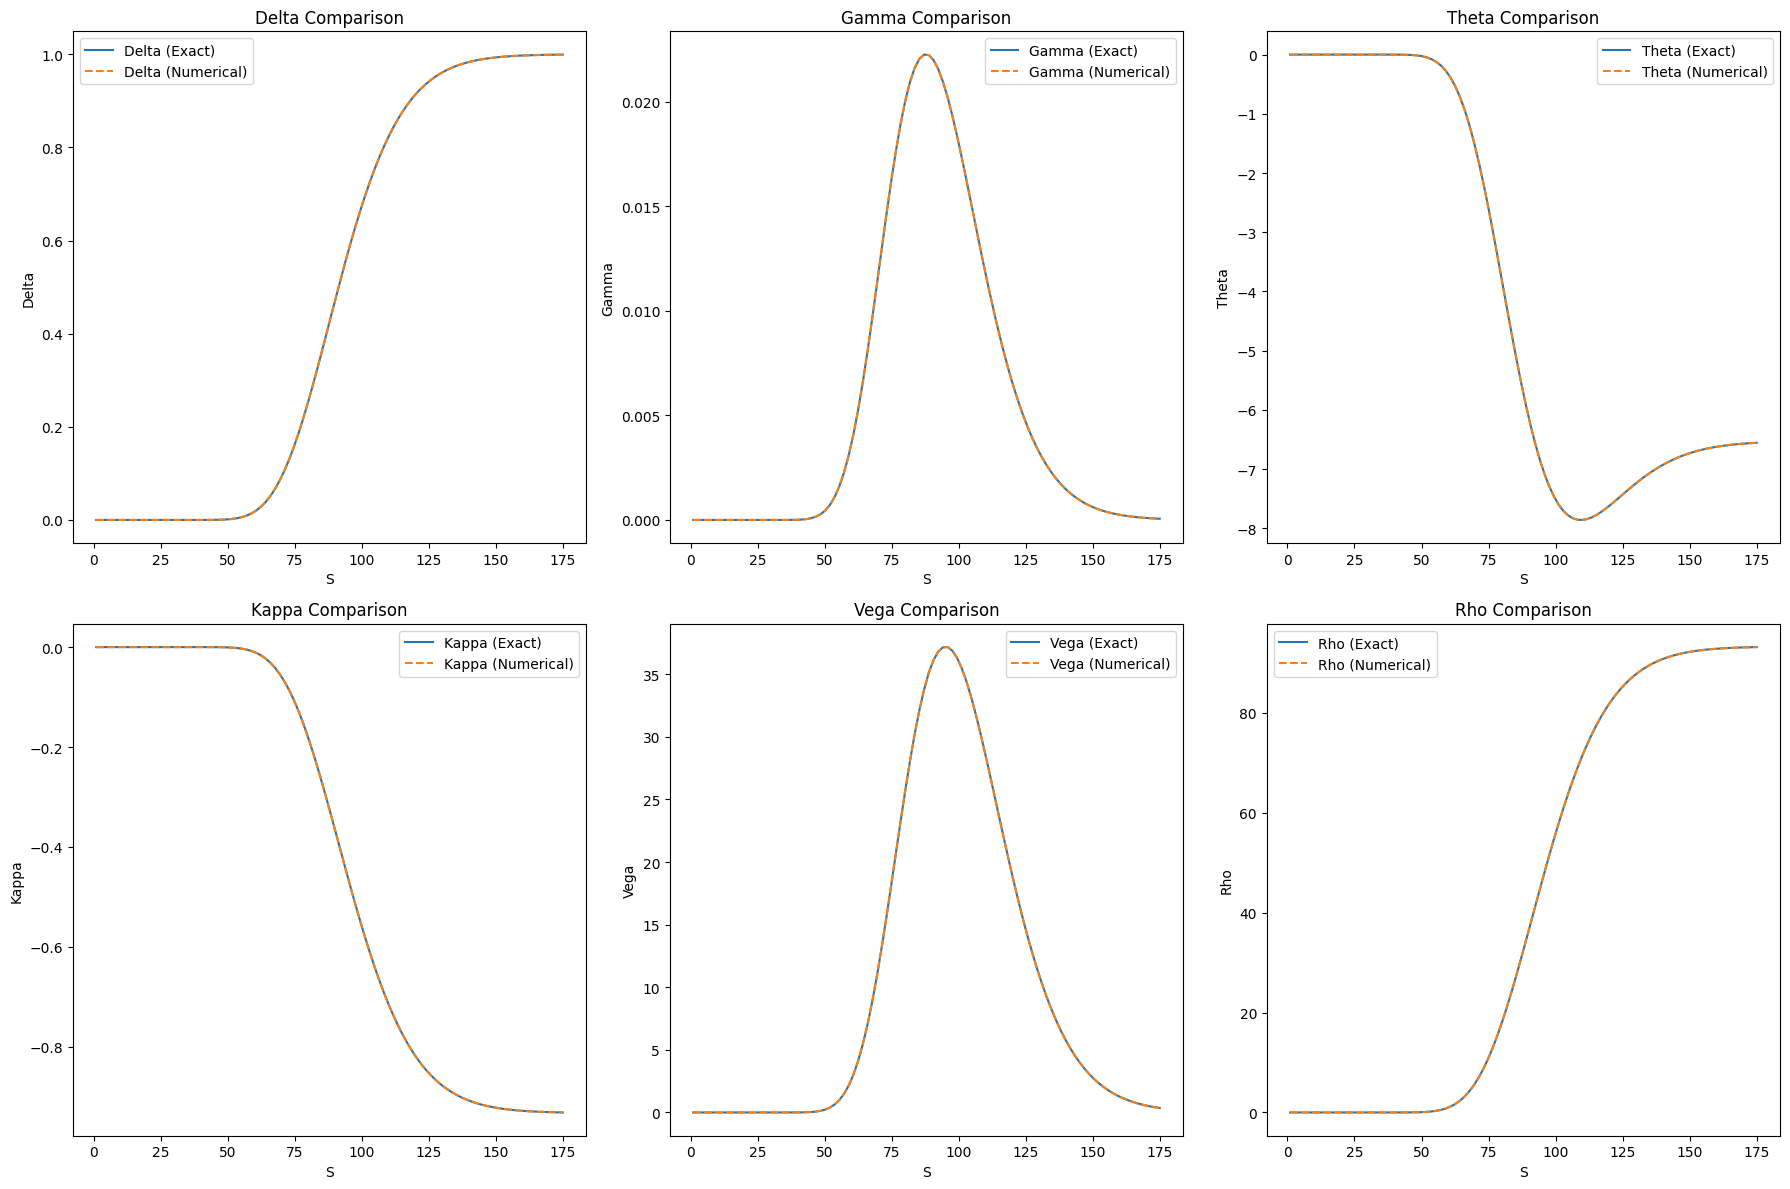

In [25]:
plot_numerical_greeks(S, K, r, T, sigma, 'call')

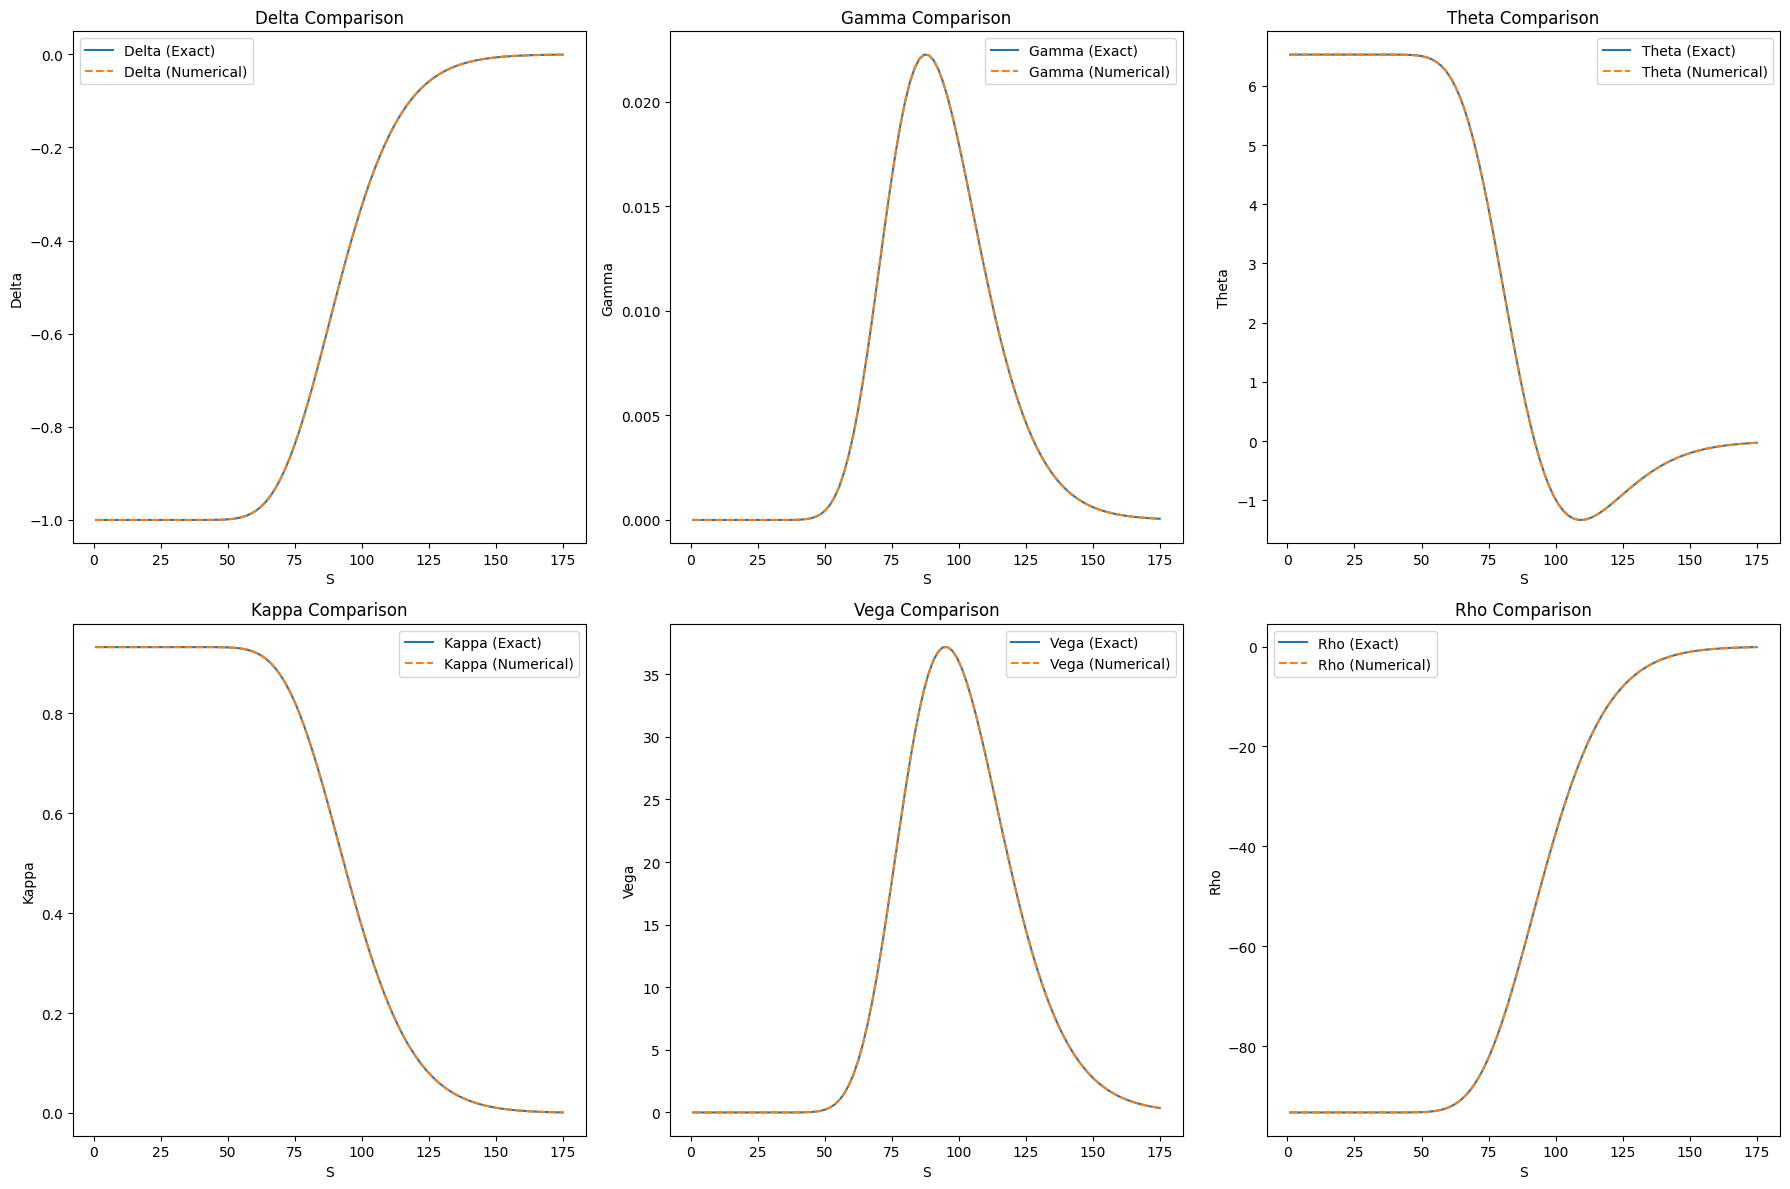

In [26]:
plot_numerical_greeks(S, K, r, T, sigma, 'put')

Задача. Постройте график трехмерной поверхности для описания зависимости греческих коэффициентов опциона  
*   кол,
*   пут

от стоимости базового актива и
количества дней до экспирации.

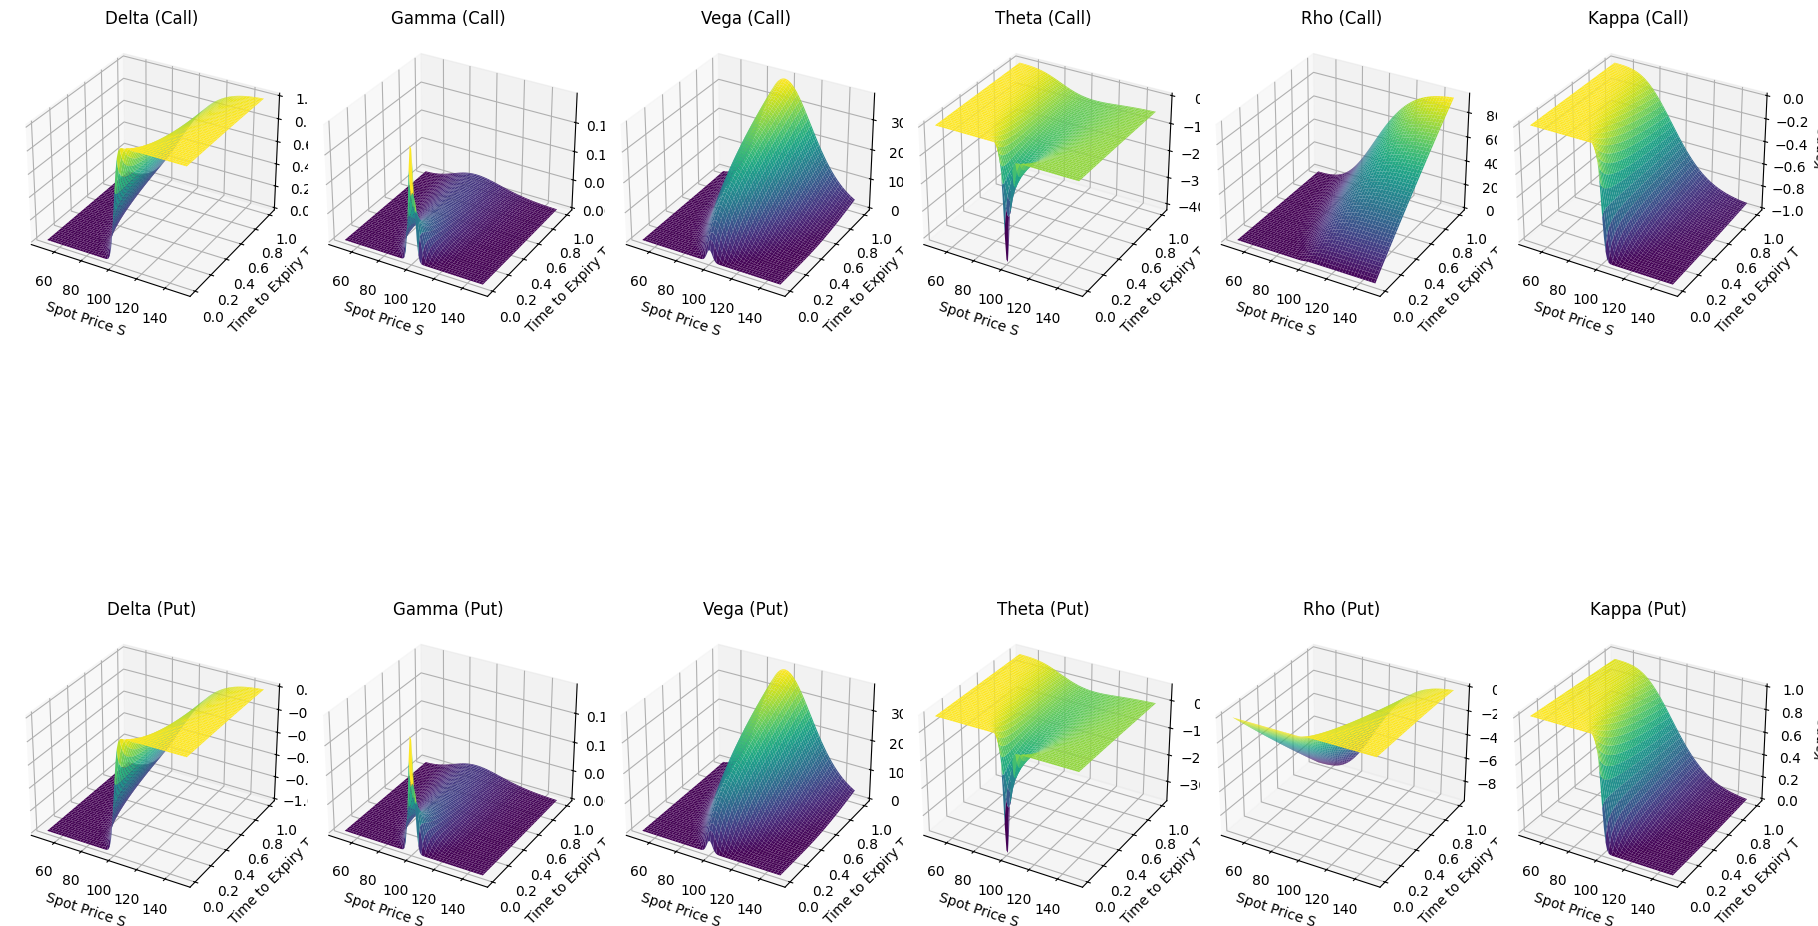

In [27]:
# Параметры
K = 100      # Цена страйка
r = 0.05     # Безрисковая ставка
sigma = 0.2  # Волатильность
option_types = ['call', 'put']

# Диапазон значений
S_values = np.linspace(50, 150, 100)     # Стоимость базового актива
T_values = np.linspace(0.01, 1, 100)     # Время до экспирации (в годах)

# Создаем сетку значений
S_grid, T_grid = np.meshgrid(S_values, T_values)

# Создаем фигуру для графиков
fig = plt.figure(figsize=(18, 15))

# Графики для каждого грека и типа опциона
for i, greek_name in enumerate(['delta', 'gamma', 'vega', 'theta', 'rho', 'kappa']):
    for j, option_type in enumerate(option_types):
        
        # Вычисление значений греков
        if greek_name == 'delta':
            Z = delta(S_grid, K, r, T_grid, sigma, option_type)
        elif greek_name == 'gamma':
            Z = gamma(S_grid, K, r, T_grid, sigma)
        elif greek_name == 'vega':
            Z = vega(S_grid, K, r, T_grid, sigma)
        elif greek_name == 'theta':
            Z = theta(S_grid, K, r, T_grid, sigma, option_type)
        elif greek_name == 'rho':
            Z = rho(S_grid, K, r, T_grid, sigma, option_type)
        elif greek_name == 'kappa':
            Z = kappa(S_grid, K, r, T_grid, sigma, option_type)

        ax = fig.add_subplot(2, 6, i + 1 + j * 6, projection='3d')
        ax.plot_surface(S_grid, T_grid, Z, cmap='viridis')
        ax.set_title(f'{greek_name.capitalize()} ({option_type.capitalize()})')
        ax.set_xlabel('Spot Price S')
        ax.set_ylabel('Time to Expiry T')
        ax.set_zlabel(greek_name.capitalize())

# Отображение графиков
plt.tight_layout()
plt.show()

# Опционная стратегия

## Задача (по вариантам)

Задача. С использование досок опционов [Nasdaq](https://www.nasdaq.com/market-activity/stocks/aapl/option-chain) или [MOEX](https://www.moex.com/ru/derivatives/optionsdesk.aspx) выберите ликвидный актив и реализуейте две [опционных стратегий](https://www.option.ru/glossary/strategy),
$i$ и $i+12$, где $i$ -- ваша фамилия по алфавиту:

1.   Покупка опциона колл. Long Call
1. Продажа опциона колл. Short Call
1. Покупка опциона пут. Long Put
1. Продажа опциона пут. Short Put
1. Бычий колл спрэд. Bull Call Spread
1. Бычий пут спрэд. Bull Put Spread
1. Медвежий колл спрэд. Bear Call Spread
1. Медвежий пут спрэд. Bear Put Spread
1. Покупка бабочки. Long Butterfly
1. Продажа бабочки. Short Butterfly
1. Покупка кондора. Long Condor
1. Продажа кондора. Short Condor
1. Покупка стрэддла. Long Straddle
1. Продажа стрэддла. Short Straddle
1. Покупка стрэнгла. Long Strangle
1. Продажа стрэнгла. Short Strangle
1. Пропорциональный колл спрэд. Call Ratio Spread
1. Пропорциональный пут спрэд. Put Ratio Spread
1. Пропорциональный обратный колл спрэд. Call Ratio Backspread
1. Пропорциональный обратный пут спрэд. Put Ratio Backspread
1. Синтетический длинный фьючерс. Synthetic Long Futures
1. Синтетический короткий фьючерс. Synthetic Short Futures
1. Стрэп. Strap
1. Стрип. Strip
1. Обратный бычий спрэд. Bull Backspread
1. Обратный медвежий спрэд. Bear Backspread

Проанализируйте как влияет соотношение  спот цены базового актива $S$ и цены страйк $K$ для

опциона call:

*   $S > K$ -- в деньгах (in the money),   
*   $S = K$ -- около денег (at the money),
*   $S < K$ --  вне денег (out of the money) и

опциона put:
*   $S < K$ -- в деньгах (in the money),
*   $S = K$ -- около денег (at the money),  
*   $S > K$ -- вне денег (out of the money).

Определите максимальную прибыль и потери, если цена базового актива может вырасти в два раза (меньше нуля не может быть). Определите интервал безубыточности стратегии с учетом премии.

Постройте график функции выплат для каждой опционной стратегии.

Мой вариант 5 и 17 
1. Бычий колл спрэд. Bull Call Spread
2. Пропорциональный колл спрэд. Call Ratio Spread

For BTC-20NOV24 option 

In [28]:
def calculate_payoff(S, K1, K2, C1, C2, strategy_type):
    """
    Общая функция для вычисления выплат по стратегиям Bull Call Spread и Call Ratio Spread.
    
    Параметры:
    - S: Массив цен базового актива
    - K1, K2: Страйки (K1 < K2)
    - C1, C2: Премии купленного и проданного опциона соответственно
    - strategy_type: Тип стратегии ("bull_call" или "call_ratio")
    
    Возвращает:
    - Массив выплат стратегии
    """
    if strategy_type == "bull_call":
        payoff = np.where(S < K1, -C1 + C2,
                          np.where(S < K2, S - K1 - C1 + C2,
                                   K2 - K1 - C1 + C2))
    elif strategy_type == "call_ratio":
        payoff = np.where(S < K1, -C1 + 2 * C2,
                      np.where(S < K2, S - K1 - C1 + 2 * C2,
                               (S - K1 - C1) - 2 * (S - K2) + 2 * C2))
    else:
        raise ValueError("Invalid strategy type. Use 'bull_call' or 'call_ratio'.")
    
    return payoff

def plot_payoff(S, payoffs, strategy_names, K1, K2):
    """
    Построение графиков выплат для нескольких стратегий.
    
    Параметры:
    - S: Массив цен базового актива
    - payoffs: Список массивов выплат
    - strategy_names: Список названий стратегий
    - K1, K2: Страйки (для отображения вертикальных линий)
    """
    plt.figure(figsize=(10, 6))
    
    for payoff, name in zip(payoffs, strategy_names):
        plt.plot(S, payoff, label=name)

            # Вычисление точек безубыточности
        break_even_points = calculate_break_even_points(S, payoff)
        
        # Добавление точек безубыточности на график
        for bep in break_even_points:
            plt.scatter(bep, 0, color='red', zorder=5, label=f"Break-even" if name == strategy_names[0] else None)
    
    plt.axhline(0, color='black', linewidth=1, linestyle='-')
    plt.axvline(K1, color='gray', linestyle='--', label=f"Strike K1 = {K1}")
    plt.axvline(K2, color='gray', linestyle='--', label=f"Strike K2 = {K2}")
    plt.title("Payoff Diagrams")
    plt.xlabel("Spot Price")
    plt.ylabel("Payoff")
    plt.legend()
    plt.grid()
    plt.show()

def calculate_break_even_points(S, payoff):
    """
    Вычисление точек безубыточности, где payoff равен 0.
    
    Параметры:
    - S: Массив цен базового актива.
    - payoff: Массив выплат.
    
    Возвращает:
    - Список точек безубыточности.
    """
    zero_crossings = np.where(np.diff(np.sign(payoff)))[0]
    break_even_points = S[zero_crossings]
    return break_even_points

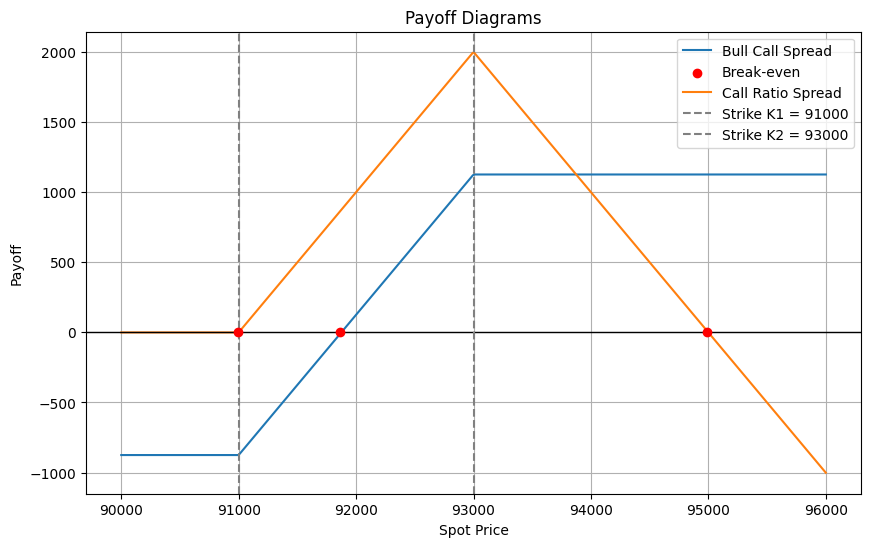

Max profit from bull call stragedy is 1125.0
Max profit from call ratio stragedy is 1992.98797595191


In [29]:
# Параметры стратегии
S = np.linspace(90000, 96000, 500)  # Диапазон цен базового актива
K1, K2 = 91000, 93000             # Низкий и высокий страйки
C1, C2 = 1749, 874                # Премии купленного и проданного опциона

# Вычисление выплат
bull_call_payoff = calculate_payoff(S, K1, K2, C1, C2, "bull_call")
call_ratio_payoff = calculate_payoff(S, K1, K2, C1, C2, "call_ratio")

# Построение графика
plot_payoff(S, 
            [bull_call_payoff, call_ratio_payoff], 
            ["Bull Call Spread", "Call Ratio Spread"], 
            K1, K2)

print(f'Max profit from bull call stragedy is {np.max(bull_call_payoff)}')
print(f'Max profit from call ratio stragedy is {np.max(call_ratio_payoff)}')

## Задача (оптимальный набор)

С использование доски опционов [Nasdaq](https://www.nasdaq.com/market-activity/stocks/aapl/option-chain) найдите оптимальный набор опционных контрактов:

$$
X=\{X_c, X_p\},
$$

где

$$
X_c=\{x_i^c \in \mathbb{Z}: L\le x_i^c \le U, i \in I\},
$$

$$
X_p=\{x_i^p \in \mathbb{Z}: L \le x_i^p \le U, i \in I\},
$$

здесь \( x_i^c \), \( x_i^p > 0 \) — количество опционов колл и пут для покупки, \( x_i^c \), \( x_i^p < 0 \) — для продажи. Если \( x_i^c = 0 \) или \( x_i^p = 0 \), то \( i \)-ый контракт не входит в портфель.

$$
L < 0 \quad \text{и} \quad U > 0
$$

— нижняя и верхняя границы количества контрактов в портфеле соответственно,

$$
I = \{1, 2, \ldots, n\}
$$

— набор индексов.

### Предположения
- Покупки и продажи опционов можно осуществлять по ask- и bid-ценам.
- Можно занимать короткие и длинные позиции с учетом ликвидности контракта.
- Стратегия должна иметь защиту от падения и роста цен страйк на \( x \)% от стоимости базового актива в момент времени \( T \).
- Максимальный убыток стратегии ограничен величиной \( \mathcal{L} \), равной \( y \)% от стоимости базового актива в момент времени \( t=0 \).
- Стратегия имеет начальную стоимость \( C(t, X) \), равную \( w \) условных единиц капитала.
https://arxiv.org/pdf/1707.02087

In [30]:
import cvxpy as cp

Количество call: [5. 5. 5. 5. 0. 0. 0. 0. 0. 0.]
Количество put: [0. 0. 0. 0. 0. 0. 5. 5. 5. 5.]
Оптимальная стоимость: 927.6083207295311


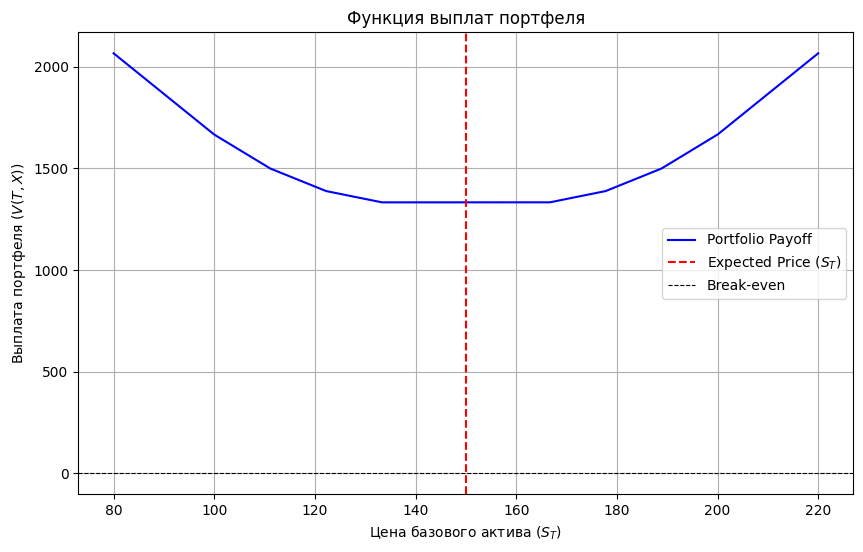

In [41]:
n = 10  # количество страйков
strike_prices = np.linspace(100, 200, n)  # пример страйков
ask_prices_call = np.random.uniform(5, 15, n)  # ask-цены call
bid_prices_call = ask_prices_call - 1  # bid-цены call
ask_prices_put = np.random.uniform(5, 15, n)  # ask-цены put
bid_prices_put = ask_prices_put - 1  # bid-цены put
expected_price = 150  # ожидаемая цена в момент T
initial_capital = 1000  # начальный капитал
max_loss = -200  # максимальный убыток
L, U = -5, 5  # ограничения на количество контрактов

# Предварительный расчет выплат для call и put
payoff_call = np.maximum(expected_price - strike_prices, 0)  # выплата по call
payoff_put = np.maximum(strike_prices - expected_price, 0)  # выплата по put

# Переменные для оптимизации
x_call = cp.Variable(n, integer=True)  # количество call
x_put = cp.Variable(n, integer=True)  # количество put

# Вспомогательные переменные для абсолютных значений
abs_x_call = cp.Variable(n)
abs_x_put = cp.Variable(n)

# Ограничения для абсолютных значений
constraints = [
    abs_x_call >= x_call,
    abs_x_call >= -x_call,
    abs_x_put >= x_put,
    abs_x_put >= -x_put
]

# Целевая функция
payoff = cp.sum(cp.multiply(x_call, payoff_call)) + cp.sum(cp.multiply(x_put, payoff_put))
cost = cp.sum(cp.multiply(cp.pos(x_call), ask_prices_call) + cp.multiply(cp.neg(x_call), bid_prices_call)) + \
       cp.sum(cp.multiply(cp.pos(x_put), ask_prices_put) + cp.multiply(cp.neg(x_put), bid_prices_put))
objective = cp.Maximize(payoff - cost)

# Добавление ограничений
constraints += [
    cp.sum(abs_x_call) + cp.sum(abs_x_put) == initial_capital,  # общая стоимость
    payoff - cost >= max_loss,  # ограничение на убыток
    x_call >= L, x_call <= U,  # ликвидность
    x_put >= L, x_put <= U
]

# Решение задачи оптимизации
problem = cp.Problem(objective, constraints)
problem.solve()

print("Количество call:", x_call.value)
print("Количество put:", x_put.value)
print("Оптимальная стоимость:", problem.value)

# Построение графика выплат
asset_prices = np.linspace(80, 220, 500)  # Диапазон цен базового актива
portfolio_payoff = np.zeros_like(asset_prices)

for i in range(n):
    portfolio_payoff += x_call.value[i] * np.maximum(asset_prices - strike_prices[i], 0)
    portfolio_payoff += x_put.value[i] * np.maximum(strike_prices[i] - asset_prices, 0)

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(asset_prices, portfolio_payoff, label="Portfolio Payoff", color="blue")
plt.axvline(expected_price, color='red', linestyle='--', label="Expected Price ($S_T$)")
plt.axhline(0, color='black', linestyle='--', linewidth=0.8, label="Break-even")
plt.title("Функция выплат портфеля")
plt.xlabel("Цена базового актива ($S_T$)")
plt.ylabel("Выплата портфеля ($V(T, X)$)")
plt.legend()
plt.grid()
plt.show()
